In [1]:
import scanpy as sc
import random
import numpy
import pandas

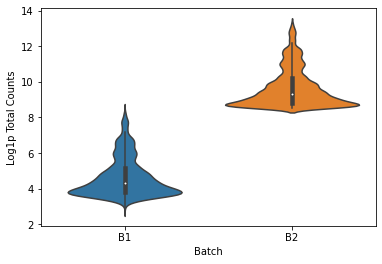

In [3]:
import seaborn as sns
ax = sns.violinplot(data=sdf,x="Batch",y="Log1p Total Counts", save="total_log_counts.pdf")

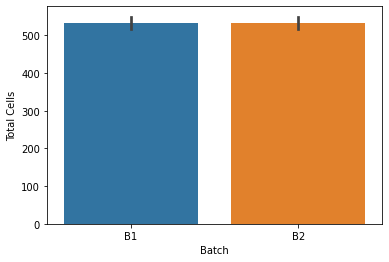

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(data=sdf,x="Batch",y="Total Cells",errorbar="sd")
plt.savefig("/Users/ceglian/barplot.pdf")

In [18]:
import numpy
import random
adata = sc.read("tica.h5ad")
# sc.pp.filter_cells(adata,min_counts=4000)
# print(adata)

# batch1 = []
# batch2 = []
# for x in adata.obs.index:
#     if random.uniform(0,1) < 0.5:
#         batch1.append(x)
#     else:
#         batch2.append(x)
# adata1 = adata[adata.obs.index.isin(batch1)]
# adata2 = adata[adata.obs.index.isin(batch2)]
# target_counts = numpy.max(adata1.X.todense()) / 2
# sc.pp.downsample_counts(adata1,total_counts=target_counts)
# sc.pp.filter_cells(adata2,min_counts=1)
# sc.pp.filter_cells(adata1,min_counts=1)

# adata = adata1.concatenate(adata2,batch_categories=["B1","B2"],batch_key="batch")
# sc.pp.calculate_qc_metrics(adata,inplace=True)
ct = []
for x in adata.obs["cell_type"]:
    if "T " in x:
        ct.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct.append("Myeloid")
    elif "mono" in x.lower():
        ct.append("Myeloid")
    elif "TAM" in x:
        ct.append("Myeloid")
    elif "B " in x:
        ct.append("B/Plasma")
    elif "NK" in x:
        ct.append("T Cell")
    elif "Th" in x:
        ct.append("T Cell")
    elif "Mast" in x:
        ct.append("Myeloid")
    else:
        ct.append(x)
print(set(ct))
adata.obs["coarse_cell_type"] = ct

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
dataset = GeneVectorDataset(adata)



{'T Cell', 'B/Plasma', 'Myeloid'}
Loading Expression.
Indexing expression.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2694738/2694738 [00:01<00:00, 1842576.20it/s]


Finished.


In [19]:
def get_ranks(embed):
    pairs = dict()
    for x in tqdm.tqdm(embed.embeddings):
        for y in embed.embeddings:
            if x==y: continue
            vec1 = embed.embeddings[x]
            vec2 = embed.embeddings[y]
            dist = 1. - distance.cosine(vec1, vec2)
            pairs[(x,y)] = dist
    import operator
    ranks = sorted(pairs.items(), key=operator.itemgetter(1))
    return [x[0] for x in list(reversed(ranks))]


In [20]:
from scipy.spatial import distance
import numpy
def get_df(embed, norm, subset):
    xs = []
    ys = []
    raws = []
    normt = [] 
    sources = []
    ranks = get_ranks(embed)
    rankd = dict(zip(ranks,range(1,len(ranks))))
    pairs = [tuple(x[:2]) for x in subset]
    vpairs = set(pairs).intersection(set(ranks))
    for x,y,source in tqdm.tqdm(subset):
        if (x,y) in rankd:
            raws.append(rankd[(x,y)])
            xs.append(x)
            ys.append(y)
            normt.append(norm)
            sources.append(source)
    import pandas
    df = pandas.DataFrame.from_dict({"Gene1":xs,"Gene2":ys,"distance".format(norm):raws,"Norm":normt,"Source":sources})
    return df

In [53]:
import celltypist
from celltypist import models

In [55]:
import celltypist
from celltypist import models
models.download_models(model = 'Healthy_COVID19_PBMC.pkl')
model = models.Model.load(model = "Healthy_COVID19_PBMC.pkl")

📂 Storing models in /Users/ceglian/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Healthy_COVID19_PBMC.pkl (file exists)


In [63]:
vpairs_c8 = set()
for ct in model.cell_types:
    markers = model.extract_top_markers(ct,10)
    for m1 in markers:
        for m2 in markers:
            if m1 != m2:
                vpairs_c8.add((m1,m2))
                vpairs_c8.add((m2,m1))

In [68]:
len(vpairs_c8)

4162

In [64]:
msigdb_markers = set()
for p in vpairs_c8:
    msigdb_markers.add(p[0])
    msigdb_markers.add(p[1])
print(len(msigdb_markers))

266


In [84]:
import glob
import os
ms = glob.glob(os.path.join(models.models_path,"*pkl"))
model_stack = []
allcts = []
for m in ms:
    m = m.split("/")[-1]
    if "mouse" not in m.lower():
        model = models.Model.load(model = m)
        model_stack.append(model)
        allcts += list(model.cell_types)
allcts = list(set(allcts))

tcell_types = []
bcell_types = []
mono_types = []
for ct in allcts:
    if "T " in ct:
        tcell_types.append(ct)
for ct in allcts:
    if "B " in ct:
        bcell_types.append(ct)
for ct in allcts:
    if "Mono" in ct:
        mono_types.append(ct)

In [86]:
import collections
topx = 10
topy = 10

tcell_markers = []
bcell_markers = []
mono_markers = []
for model in model_stack:
    for ct in model.cell_types:
        if ct in tcell_types:
            tcell_markers.append(set(model.extract_top_markers(ct,topx)))
    for ct in model.cell_types:
        if ct in bcell_types:
            bcell_markers.append(set(model.extract_top_markers(ct,topx)))
    for ct in model.cell_types:
        if ct in mono_types:
            mono_markers.append(set(model.extract_top_markers(ct,topx)))

counts = []
for x in tcell_markers:
    counts += x
tmarkers = list(set(counts))
marker_counts = collections.defaultdict(int)
for tcell_marker in tmarkers:
    marker_counts[tcell_marker] += counts.count(tcell_marker)
import operator
sorted_t_markers = list(reversed(sorted(marker_counts.items(), key=operator.itemgetter(1))))
tmarkers = [x[0] for x in sorted_t_markers[:topy]]
tmarkers

counts = []
for x in mono_markers:
    counts += x
mmarkers = list(set(counts))
marker_counts = collections.defaultdict(int)
for mono_marker in mmarkers:
    marker_counts[mono_marker] += counts.count(mono_marker)
import operator
sorted_mono_markers = list(reversed(sorted(marker_counts.items(), key=operator.itemgetter(1))))
mmarkers = [x[0] for x in sorted_mono_markers[:topy]]
mmarkers

counts = []
for x in bcell_markers:
    counts += x
bmarkers = list(set(counts))
marker_counts = collections.defaultdict(int)
for bcell_marker in bmarkers:
    marker_counts[bcell_marker] += counts.count(bcell_marker)
import operator
sorted_b_markers = list(reversed(sorted(marker_counts.items(), key=operator.itemgetter(1))))
bmarkers = [x[0] for x in sorted_b_markers[:topy]]
bmarkers = set(bmarkers).difference(set(tmarkers).union(set(mmarkers)))
tmarkers = set(tmarkers).difference(set(mmarkers).union(set(mmarkers)))
mmarkers = set(mmarkers).difference(set(tmarkers).union(set(bmarkers)))
markers = dict()
print(bmarkers)
print(tmarkers)
print(mmarkers)
markers["B"] = bmarkers
markers["T"] = tmarkers
markers["M"] = markers

{'VPREB1', 'MS4A1', 'BANK1', 'CTAG2', 'CD74', 'CD79A', 'PTMA', 'LINC01644'}
{'CD3E', 'AC006115.2', 'MALAT1', 'KLRB1', 'AC009226.1', 'NKG7', 'GZMK', 'CCL5', 'AL136456.1', 'ANXA1'}
{'LYZ', 'S100A8', 'S100A9', 'HLA-DRA', 'S100A4', 'TYROBP', 'NEAT1', 'FCN1', 'FTL', 'VCAN'}


In [87]:

pairs_exc = []
for ph, genes in markers.items():
    for ph2, genes2 in markers.items():
        if ph != ph2:
            for g1 in genes:
                for g2 in genes2:
                    pairs_exc.append((g1,g2))
pairs_ct = []
for ph, genes in markers.items():
    for g in genes:
        for g2 in genes:
            if g != g2:
                pairs_ct.append((g,g2))


In [92]:
# import glob
# dfs = []
# multimapped = []
# for x in adata.var.index.tolist():
#     for y in adata.var.index.tolist():
#         if x == y: continue
#         if (x,y) in pairs_exc:
#             multimapped.append((x,y,"CellTypist Inter Cell Type"))
#         elif (x,y) in pairs_ct:
#             multimapped.append((x,y,"CellTypist Intra Cell Type"))
#         else:
#             multimapped.append((x,y,"Other"))

import tqdm
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
for x in reversed(glob.glob("*X.vec")):
    norm = x.split("/")[-1].split("_")[0]
    num = x.split("/")[-1].split("_")[2]
    try:
        embed = GeneEmbedding(x, dataset, vector="average")
        dfs.append(get_df(embed,norm,multimapped))
    except Exception as e:
        print(e)
        continue

Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1270973.07it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1257494.41it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1190025.21it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1228330.63it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1251677.23it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1245530.31it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1220969.85it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1249521.66it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1345365.86it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1347099.87it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1348305.80it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1294713.87it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1287394.43it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1281995.02it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1310665.88it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1304114.57it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1297840.65it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1297905.38it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1352492.51it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1387729.71it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1304230.26it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1346515.03it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1337240.17it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1333504.03it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1412834.98it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1298640.31it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1355922.07it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1259215.38it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1353218.46it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1342958.48it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1340763.45it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1326323.64it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1267518.97it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1299818.25it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1316502.35it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1305031.31it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1322737.10it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1314162.44it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1305322.80it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1301282.77it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1321144.34it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1329561.27it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1272120.26it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1335831.19it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1247762.78it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1277248.56it/s]


Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999000/999000 [00:00<00:00, 1290639.35it/s]


Loading average of 1st and 2nd weights.


 34%|█████████████████████████████████████▏                                                                        | 337407/999000 [00:00<00:00, 1023512.00it/s]


KeyboardInterrupt: 

In [93]:
import pandas
import seaborn as sns
df = pandas.concat(dfs)
df

,Gene1,Gene2,distance,Norm,Source
0,TMEM176A,ICA1,324316,norm,Other
1,TMEM176A,CD38,496074,norm,Other
2,TMEM176A,PDK4,92744,norm,Other
3,TMEM176A,MATK,267562,norm,Other
4,TMEM176A,CD79B,305750,norm,Other
...,...,...,...,...,...
983066,IL8,IGLC1,815535,raw,Other
983067,IL8,AL512428.1,2049,raw,Other
983068,IL8,CCL3L1,997715,raw,Other
983069,IL8,RNU6.514P,866053,raw,Other


In [94]:
# df["rank"] = numpy.max(df["distance"]) - df["distance"]
# dfx = df.groupby(['Gene1', 'Gene2','Norm','Source']).agg({'distance': ['median']}).reset_index()
rank = numpy.max(df["distance"]) - df["distance"]
df["rank"] = rank
# cd8 = dfx[dfx["Gene1"] == "CD8A"]
# cd8 = cd8[cd8["Gene2"] == "CD8B"]
rank = numpy.max(df["distance"]) - df["distance"]
df["rank"] = rank
dfx = df[df["Source"]!="Other"]

In [95]:
set(df["Source"])

{'CellTypist Inter Cell Type', 'CellTypist Intra Cell Type', 'Other'}

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 pynndescent==0.5.7


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


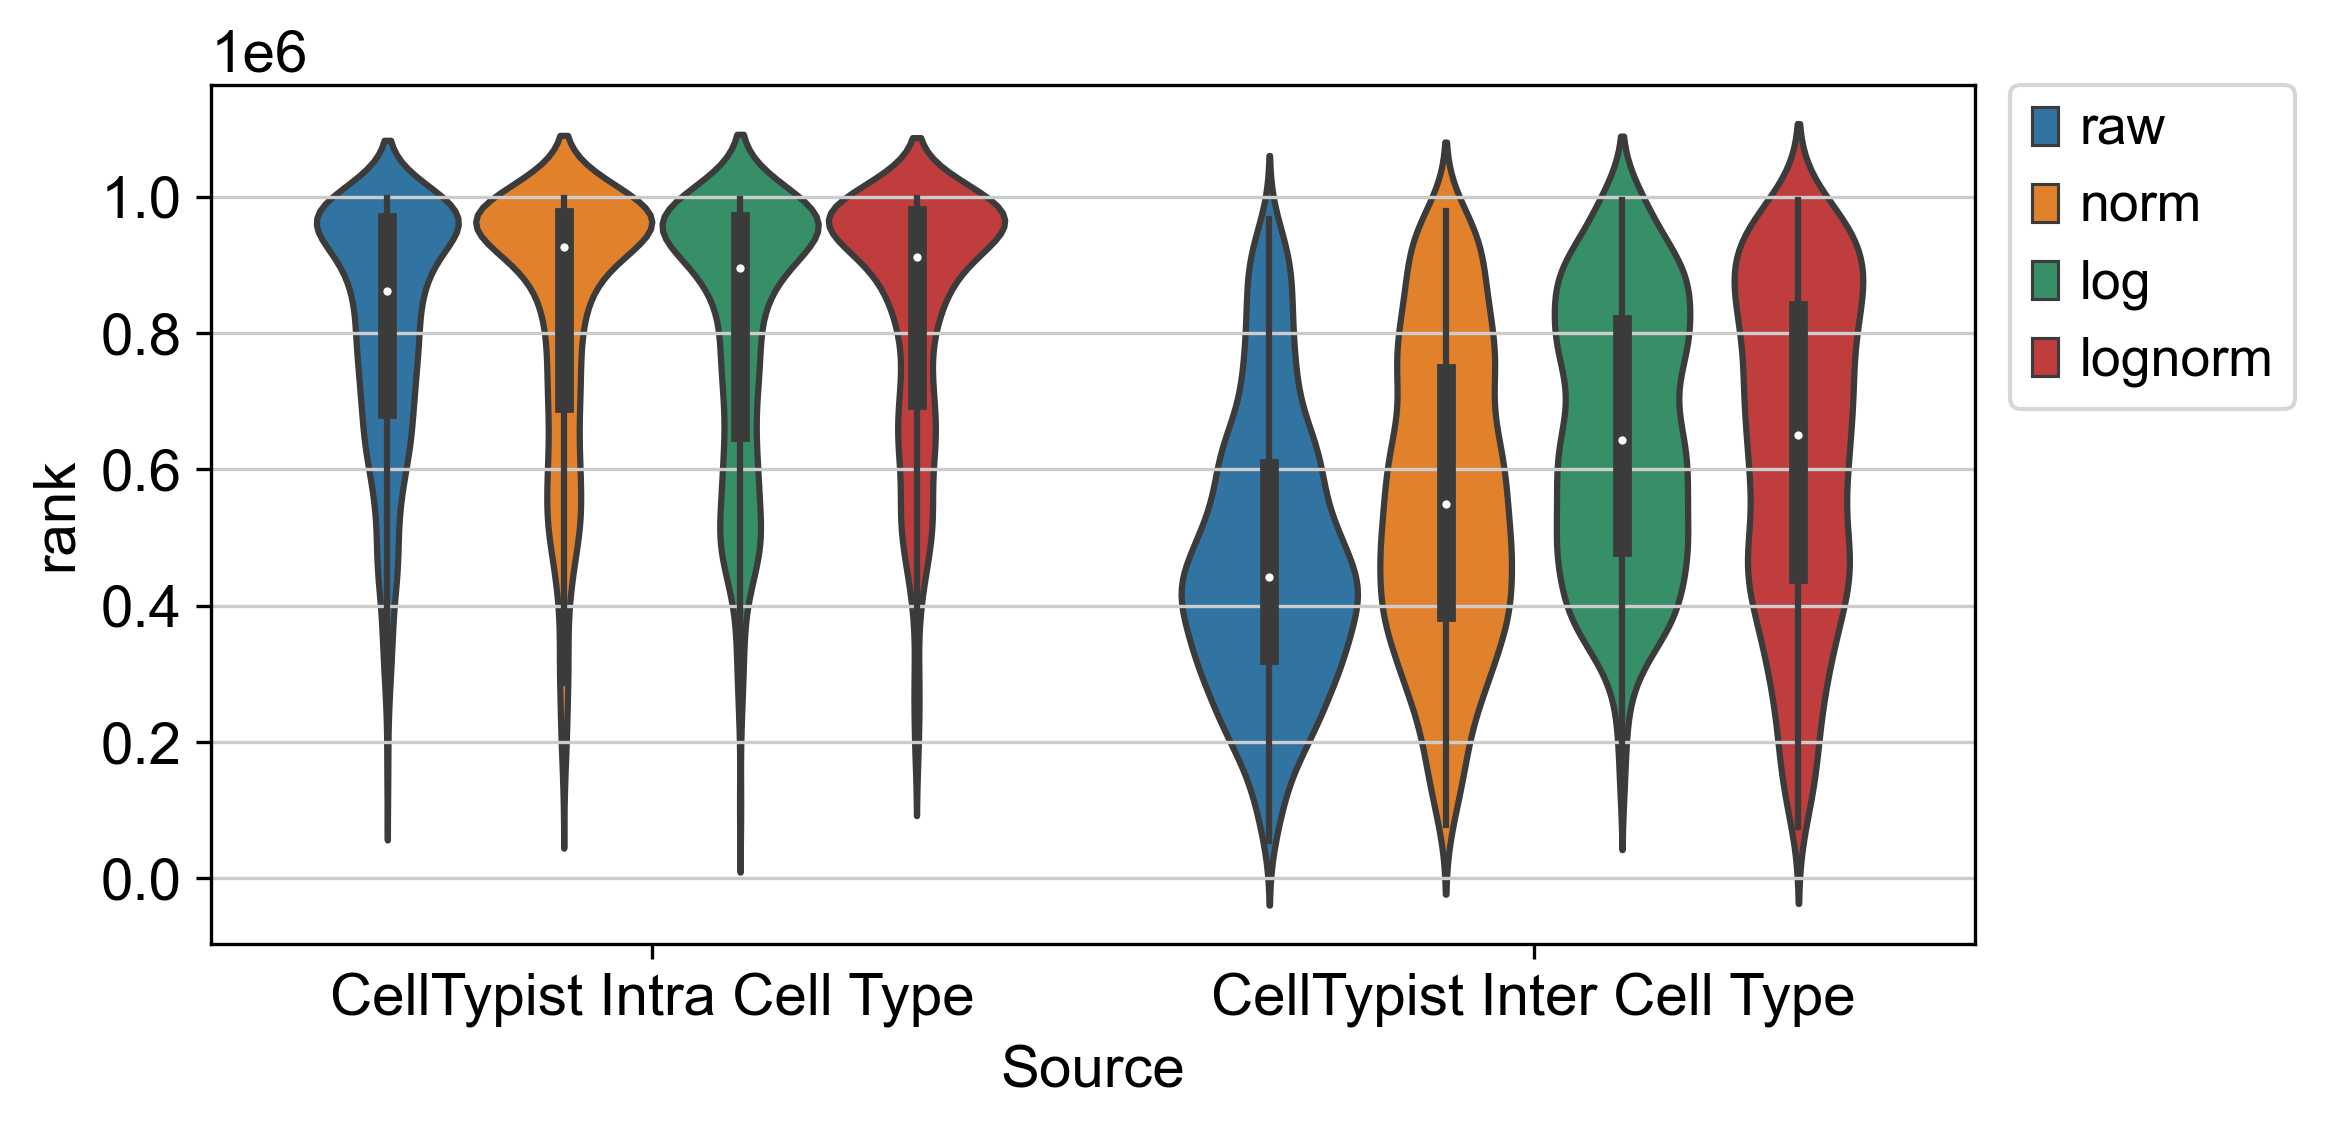

In [98]:
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')

# plt.figure(figsize=(6,4))
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.violinplot(data=dfx,ax=ax,x="Source",y="rank",hue="Norm",hue_order=["raw","norm","log","lognorm"])
#sns.swarmplot(data=dfx,ax=ax,x="Source",y="rank",hue="Norm",hue_order=["raw","norm","log","lognorm"])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("/Users/ceglian/batch.pdf")

In [42]:
dfx = df[df["Source"]=="MSigDB Inter Cell Type"]

In [43]:
dfx["pair"] = ["{}-{}".format(g1,g2) for g1,g2 in zip(dfx["Gene1"],dfx["Gene2"])]
dfx

/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_10137/3221460666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["pair"] = ["{}-{}".format(g1,g2) for g1,g2 in zip(dfx["Gene1"],dfx["Gene2"])]


,Gene1,Gene2,distance,Norm,Source,rank,pair
0,TMEM176A,ICA1,324316,norm,MSigDB Inter Cell Type,674683,TMEM176A-ICA1
1,TMEM176A,CD38,496074,norm,MSigDB Inter Cell Type,502925,TMEM176A-CD38
2,TMEM176A,PDK4,92744,norm,MSigDB Inter Cell Type,906255,TMEM176A-PDK4
3,TMEM176A,MATK,267562,norm,MSigDB Inter Cell Type,731437,TMEM176A-MATK
4,TMEM176A,CD79B,305750,norm,MSigDB Inter Cell Type,693249,TMEM176A-CD79B
...,...,...,...,...,...,...,...
979995,CCL3L1,PTX3,797911,raw,MSigDB Inter Cell Type,201088,CCL3L1-PTX3
980011,CCL3L1,SCT,637049,raw,MSigDB Inter Cell Type,361950,CCL3L1-SCT
980024,CCL3L1,CES1,711953,raw,MSigDB Inter Cell Type,287046,CCL3L1-CES1
980052,CCL3L1,PPBP,700493,raw,MSigDB Inter Cell Type,298506,CCL3L1-PPBP


In [46]:
dfx[dfx["Gene1"] == "CD8A"]["Gene2"].tolist()

['TMEM176A',
 'ICA1',
 'CD38',
 'PDK4',
 'MATK',
 'CD79B',
 'CD9',
 'STAB1',
 'PLAUR',
 'ZBTB32',
 'TYROBP',
 'CD22',
 'CD6',
 'SLC11A1',
 'CD74',
 'BIRC3',
 'SLAMF7',
 'SH2D2A',
 'IKZF2',
 'GRN',
 'APBA2',
 'MYOM2',
 'VCAN',
 'MSR1',
 'CAPG',
 'HERPUD1',
 'SLC2A3',
 'SPI1',
 'STAG3',
 'CLEC2D',
 'RORA',
 'TCOF1',
 'TFRC',
 'FCGR2B',
 'PTGS2',
 'TXK',
 'FSCN1',
 'ACTB',
 'CST7',
 'ITM2A',
 'HSP90AA1',
 'TCF7',
 'MEF2C',
 'FCN1',
 'FTL',
 'SIRPG',
 'ICAM1',
 'LYZ',
 'CD200',
 'CLSPN',
 'CREM',
 'GADD45B',
 'DERL3',
 'LGALS2',
 'LGALS1',
 'CENPM',
 'XBP1',
 'TIMP3',
 'HMOX1',
 'APOBEC3H',
 'IL2RB',
 'CTSG',
 'GZMB',
 'LGMN',
 'TCL1A',
 'NFKBIA',
 'PLTP',
 'CD40',
 'SLA2',
 'CTSZ',
 'CST3',
 'PIM2',
 'CD40LG',
 'TIMP1',
 'TNFSF13B',
 'ACP5',
 'RGCC',
 'TSC22D1',
 'SMPD3',
 'FCER2',
 'PLD3',
 'EBI3',
 'CD79A',
 'NKG7',
 'NAMPT',
 'CPVL',
 'HSPB1',
 'TSPAN13',
 'TMEM176B',
 'PTGDS',
 'GATA3',
 'SPOCK2',
 'LIPA',
 'PPIF',
 'RASD1',
 'CCL2',
 'AREG',
 'CTSC',
 'MS4A6A',
 'MS4A4A',
 'CD5',
 'P

In [121]:
dfx = df[df["distance"] < 10000]

In [122]:
dfx["pair"] = ["{}-{}".format(g1,g2) for g1,g2 in zip(dfx["Gene1"],dfx["Gene2"])]

/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_68280/2819397738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["pair"] = ["{}-{}".format(g1,g2) for g1,g2 in zip(dfx["Gene1"],dfx["Gene2"])]


In [10]:
markers = dict()
markers["T Cell"] = ["CD3D","CD3G","CD3E","IL32","TRAC","CD2"]
markers["B/Plasma"] = ["CD79A","CD79B","MZB1","CD19","BANK1"]
markers["Myeloid"] = ["LYZ","CST3","AIF1","CD68","C1QA","C1QB","C1QC"]

In [11]:
pairs_exc = []
for ph, genes in markers.items():
    for ph2, genes2 in markers.items():
        if ph != ph2:
            for g1 in genes:
                for g2 in genes2:
                    pairs_exc.append((g1,g2))

In [12]:
df["pair"] = ["{}-{}".format(g1,g2) for g1,g2 in zip(df["Gene1"],df["Gene2"])]
df

NameError: name 'df' is not defined

In [144]:
pairs = ["{}-{}".format(p[0],p[1]) for p in pairs_exc]
dfx = df[df["pair"].isin(pairs)]
dfx

,Gene1,Gene2,distance,Norm,Source,rank,pair
4960,CD79B,IL32,140916,norm,MSigDB Cell Type,858083,CD79B-IL32
5010,CD79B,LYZ,519390,norm,Reactome,479609,CD79B-LYZ
5037,CD79B,CST3,519098,norm,Reactome,479901,CD79B-CST3
5111,CD79B,CD2,242530,norm,Multiple,756469,CD79B-CD2
5173,CD79B,CD68,541690,norm,Reactome,457309,CD79B-CD68
...,...,...,...,...,...,...,...
657474,TRAC,MZB1,508163,norm,Unannotated,490836,TRAC-MZB1
657492,TRAC,C1QB,489351,norm,Unannotated,509648,TRAC-C1QB
657493,TRAC,C1QA,735993,norm,Unannotated,263006,TRAC-C1QA
657507,TRAC,CD19,616207,norm,Unannotated,382792,TRAC-CD19


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 pynndescent==0.5.7


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


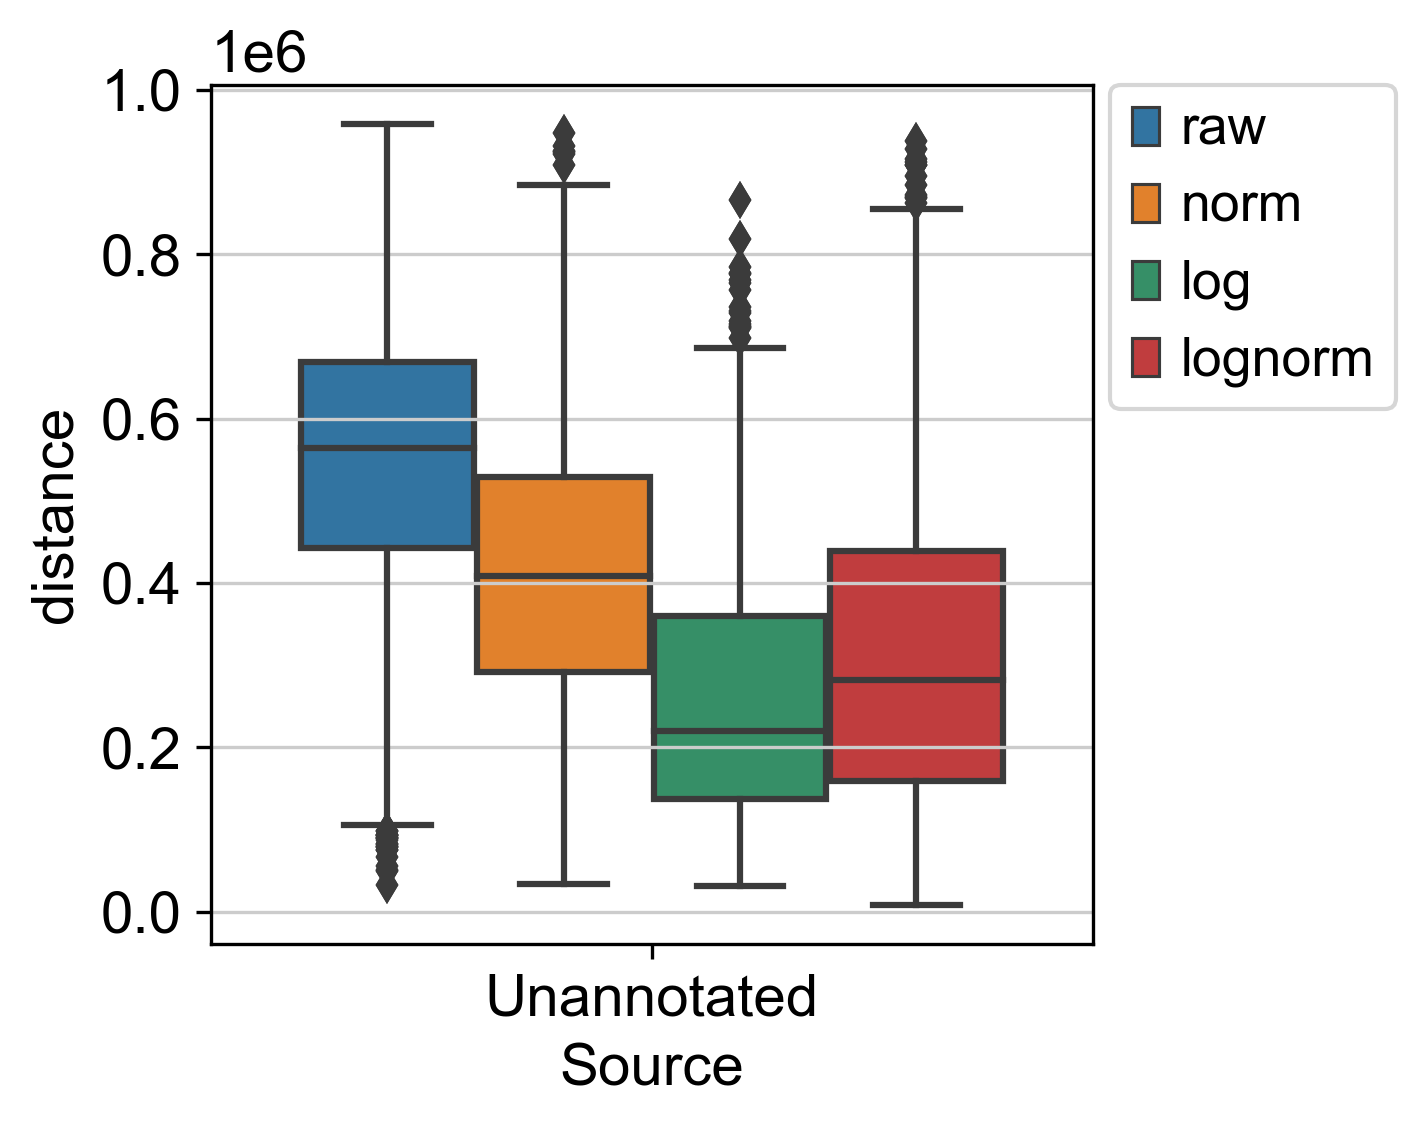

In [161]:
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')
dfx2 = dfx[dfx["Source"] == "Unannotated"]
plt.figure(figsize=(5,4))
sns.boxplot(data=dfx2,x="Source",y="distance",hue="Norm",hue_order=["raw","norm","log","lognorm"])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("/Users/ceglian/full_exc.pdf")

In [163]:
pairs_exc

[('CD3D', 'CD79A'),
 ('CD3D', 'CD79B'),
 ('CD3D', 'MZB1'),
 ('CD3D', 'CD19'),
 ('CD3D', 'BANK1'),
 ('CD3G', 'CD79A'),
 ('CD3G', 'CD79B'),
 ('CD3G', 'MZB1'),
 ('CD3G', 'CD19'),
 ('CD3G', 'BANK1'),
 ('CD3E', 'CD79A'),
 ('CD3E', 'CD79B'),
 ('CD3E', 'MZB1'),
 ('CD3E', 'CD19'),
 ('CD3E', 'BANK1'),
 ('IL32', 'CD79A'),
 ('IL32', 'CD79B'),
 ('IL32', 'MZB1'),
 ('IL32', 'CD19'),
 ('IL32', 'BANK1'),
 ('TRAC', 'CD79A'),
 ('TRAC', 'CD79B'),
 ('TRAC', 'MZB1'),
 ('TRAC', 'CD19'),
 ('TRAC', 'BANK1'),
 ('CD2', 'CD79A'),
 ('CD2', 'CD79B'),
 ('CD2', 'MZB1'),
 ('CD2', 'CD19'),
 ('CD2', 'BANK1'),
 ('CD3D', 'LYZ'),
 ('CD3D', 'CST3'),
 ('CD3D', 'AIF1'),
 ('CD3D', 'CD68'),
 ('CD3D', 'C1QA'),
 ('CD3D', 'C1QB'),
 ('CD3D', 'C1QC'),
 ('CD3G', 'LYZ'),
 ('CD3G', 'CST3'),
 ('CD3G', 'AIF1'),
 ('CD3G', 'CD68'),
 ('CD3G', 'C1QA'),
 ('CD3G', 'C1QB'),
 ('CD3G', 'C1QC'),
 ('CD3E', 'LYZ'),
 ('CD3E', 'CST3'),
 ('CD3E', 'AIF1'),
 ('CD3E', 'CD68'),
 ('CD3E', 'C1QA'),
 ('CD3E', 'C1QB'),
 ('CD3E', 'C1QC'),
 ('IL32', 'LYZ'),
 ('

In [164]:
pairs_ct = []
for ph, genes in markers.items():
    for g in genes:
        for g2 in genes:
            if g != g2:
                pairs_ct.append((g,g2))

In [165]:
adatas = dict()
adatas["raw"] = sc.read("tica.h5ad")
adata = sc.read("tica.h5ad")
sc.pp.normalize_total(adata)
adatas["norm"] = adata

adata = sc.read("tica.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adatas["lognorm"] = adata

adata = sc.read("tica.h5ad")
sc.pp.log1p(adata)
adatas["log"] = adata

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [251]:
import itertools
import tqdm
import numpy as np

def calc_mi(g1, g2, ndata):
    gn1 = numpy.array(ndata.X[:,ndata.var.index.tolist().index(g1)].T.todense())[0]
    gn2 = numpy.array(ndata.X[:,ndata.var.index.tolist().index(g2)].T.todense())[0]
    x = []
    y = []
    for x1, y1 in zip(gn1,gn2):
        if x1 > 0 or y1 > 0:
            x.append(x1)
            y.append(y1)
    pxy, xe, ye = numpy.histogram2d(x,y, density=True)
    print(xe,ye)
    pxy = pxy / pxy.sum()
    px = np.sum(pxy, axis=1)
    px = px / px.sum()
    py = np.sum(pxy, axis=0)
    py = py / py.sum()
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    mi = np.sum(pxy[nzs] * numpy.log2((pxy[nzs] / px_py[nzs])))
    return mi

mis = []
norms = []
gene1 = []
gene2 = []
ttype = []
for p in pairs_ct:
    print(p)
    mi = calc_mi(p[0],p[1],adatas["raw"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("raw")
    ttype.append("Coex")
    
    
    mi = calc_mi(p[0],p[1],adatas["norm"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("norm")
    ttype.append("Coex")
    
    mi = calc_mi(p[0],p[1],adatas["lognorm"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("lognorm")
    ttype.append("Coex")
    
    mi = calc_mi(p[0],p[1],adatas["log"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("log")
    ttype.append("Coex")

for p in pairs_exc:
    print(p)
    mi = calc_mi(p[0],p[1],adatas["raw"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("raw")
    ttype.append("Excl")
    
    
    mi = calc_mi(p[0],p[1],adatas["norm"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("norm")
    ttype.append("Excl")
    
    mi = calc_mi(p[0],p[1],adatas["lognorm"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("lognorm")
    ttype.append("Excl")
    
    mi = calc_mi(p[0],p[1],adatas["log"])
    gene1.append(p[0])
    gene2.append(p[1])
    mis.append(mi)
    norms.append("log")
    ttype.append("Excl")


('CD3D', 'CD3G')
[   0.   143.5  287.   430.5  574.   717.5  861.  1004.5 1148.  1291.5
 1435. ] [   0.   118.9  237.8  356.7  475.6  594.5  713.4  832.3  951.2 1070.1
 1189. ]
[  0.    16.35  32.7   49.05  65.4   81.75  98.1  114.45 130.8  147.15
 163.5 ] [ 0.          9.99166718 19.98333435 29.97500153 39.9666687  49.95833588
 59.95000305 69.94167023 79.9333374  89.92500458 99.91667175]
[0.         0.51029105 1.0205821  1.53087316 2.04116421 2.55145526
 3.06174631 3.57203736 4.08232841 4.59261947 5.10291052] [0.         0.4614295  0.922859   1.3842885  1.845718   2.3071475
 2.768577   3.2300065  3.691436   4.15286551 4.61429501]
[0.         0.72696166 1.45392332 2.18088498 2.90784664 3.6348083
 4.36176996 5.08873162 5.81569328 6.54265494 7.2696166 ] [0.         0.70817084 1.41634169 2.12451253 2.83268337 3.54085422
 4.24902506 4.9571959  5.66536674 6.37353759 7.08170843]
('CD3D', 'CD3E')
[   0.   143.5  287.   430.5  574.   717.5  861.  1004.5 1148.  1291.5
 1435. ] [  0.   93.7 187.

[0.         0.70817084 1.41634169 2.12451253 2.83268337 3.54085422
 4.24902506 4.9571959  5.66536674 6.37353759 7.08170843] [0.         0.75485559 1.50971117 2.26456676 3.01942234 3.77427793
 4.52913351 5.2839891  6.03884468 6.79370027 7.54855585]
('CD3E', 'CD3D')
[  0.   93.7 187.4 281.1 374.8 468.5 562.2 655.9 749.6 843.3 937. ] [   0.   143.5  287.   430.5  574.   717.5  861.  1004.5 1148.  1291.5
 1435. ]
[  0.          11.40697708  22.81395416  34.22093124  45.62790833
  57.03488541  68.44186249  79.84883957  91.25581665 102.66279373
 114.06977081] [  0.    16.35  32.7   49.05  65.4   81.75  98.1  114.45 130.8  147.15
 163.5 ]
[0.         0.47455387 0.94910774 1.42366161 1.89821548 2.37276936
 2.84732323 3.3218771  3.79643097 4.27098484 4.74553871] [0.         0.51029105 1.0205821  1.53087316 2.04116421 2.55145526
 3.06174631 3.57203736 4.08232841 4.59261947 5.10291052]
[0.       0.684375 1.36875  2.053125 2.7375   3.421875 4.10625  4.790625
 5.475    6.159375 6.84375 ] [0.       

[0.        0.6880898 1.3761796 2.0642694 2.7523592 3.440449  4.1285388
 4.8166286 5.5047184 6.1928082 6.880898 ] [0.         0.75485559 1.50971117 2.26456676 3.01942234 3.77427793
 4.52913351 5.2839891  6.03884468 6.79370027 7.54855585]
('TRAC', 'CD3D')
[   0.    313.75  627.5   941.25 1255.   1568.75 1882.5  2196.25 2510.
 2823.75 3137.5 ] [   0.   143.5  287.   430.5  574.   717.5  861.  1004.5 1148.  1291.5
 1435. ]
[  0.          12.71666489  25.43332977  38.14999466  50.86665955
  63.58332443  76.29998932  89.01665421 101.73331909 114.44998398
 127.16664886] [  0.    16.35  32.7   49.05  65.4   81.75  98.1  114.45 130.8  147.15
 163.5 ]
[0.         0.48533316 0.97066631 1.45599947 1.94133263 2.42666578
 2.91199894 3.3973321  3.88266525 4.36799841 4.85333157] [0.         0.51029105 1.0205821  1.53087316 2.04116421 2.55145526
 3.06174631 3.57203736 4.08232841 4.59261947 5.10291052]
[0.         0.80515003 1.61030006 2.4154501  3.22060013 4.02575016
 4.83090019 5.63605022 6.44120026 7

KeyboardInterrupt: 

In [243]:
midf = pandas.DataFrame.from_dict({"Gene1":gene1,"Gene2":gene2,
                                   "MI":mis,
                                   "Norm":norms,
                                   "Pair Type":ttype})

<AxesSubplot: xlabel='Pair Type', ylabel='MI'>

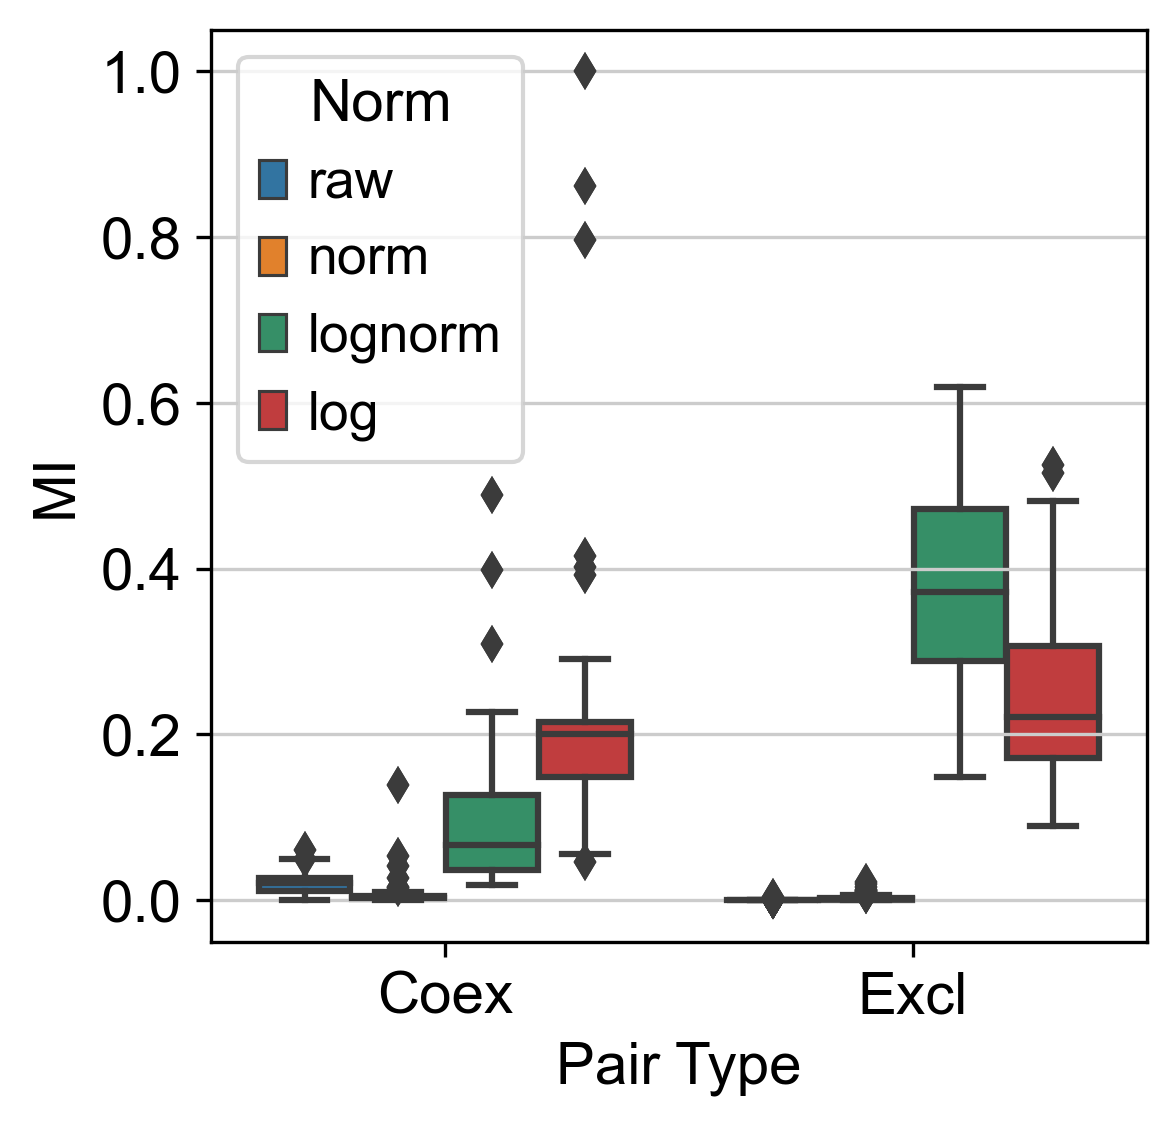

In [244]:
sns.boxplot(data=midf, x="Pair Type",y="MI",hue="Norm")

In [186]:
# dfx = midf.groupby(['Norm','Pair Type']).agg({'MI': ['mean']}).reset_index()
# dfx
exc = midf[midf["Norm"]=="norm"]
exc[exc["Pair Type"] == "Excl"].sort_values("MI",ascending=False)

,Gene1,Gene2,MI,Norm,Pair Type
405,CD3G,BANK1,0.665416,norm,Excl
757,BANK1,CD3G,0.665416,norm,Excl
425,CD3E,BANK1,0.599833,norm,Excl
761,BANK1,CD3E,0.599833,norm,Excl
421,CD3E,CD19,0.533199,norm,Excl
...,...,...,...,...,...
581,IL32,AIF1,0.016224,norm,Excl
933,LYZ,TRAC,0.014132,norm,Excl
601,TRAC,LYZ,0.014132,norm,Excl
1113,CST3,MZB1,0.013527,norm,Excl


[  0.          11.40697708  22.81395416  34.22093124  45.62790833
  57.03488541  68.44186249  79.84883957  91.25581665 102.66279373
 114.06977081] [  0.    16.35  32.7   49.05  65.4   81.75  98.1  114.45 130.8  147.15
 163.5 ]


<Figure size 600x600 with 0 Axes>

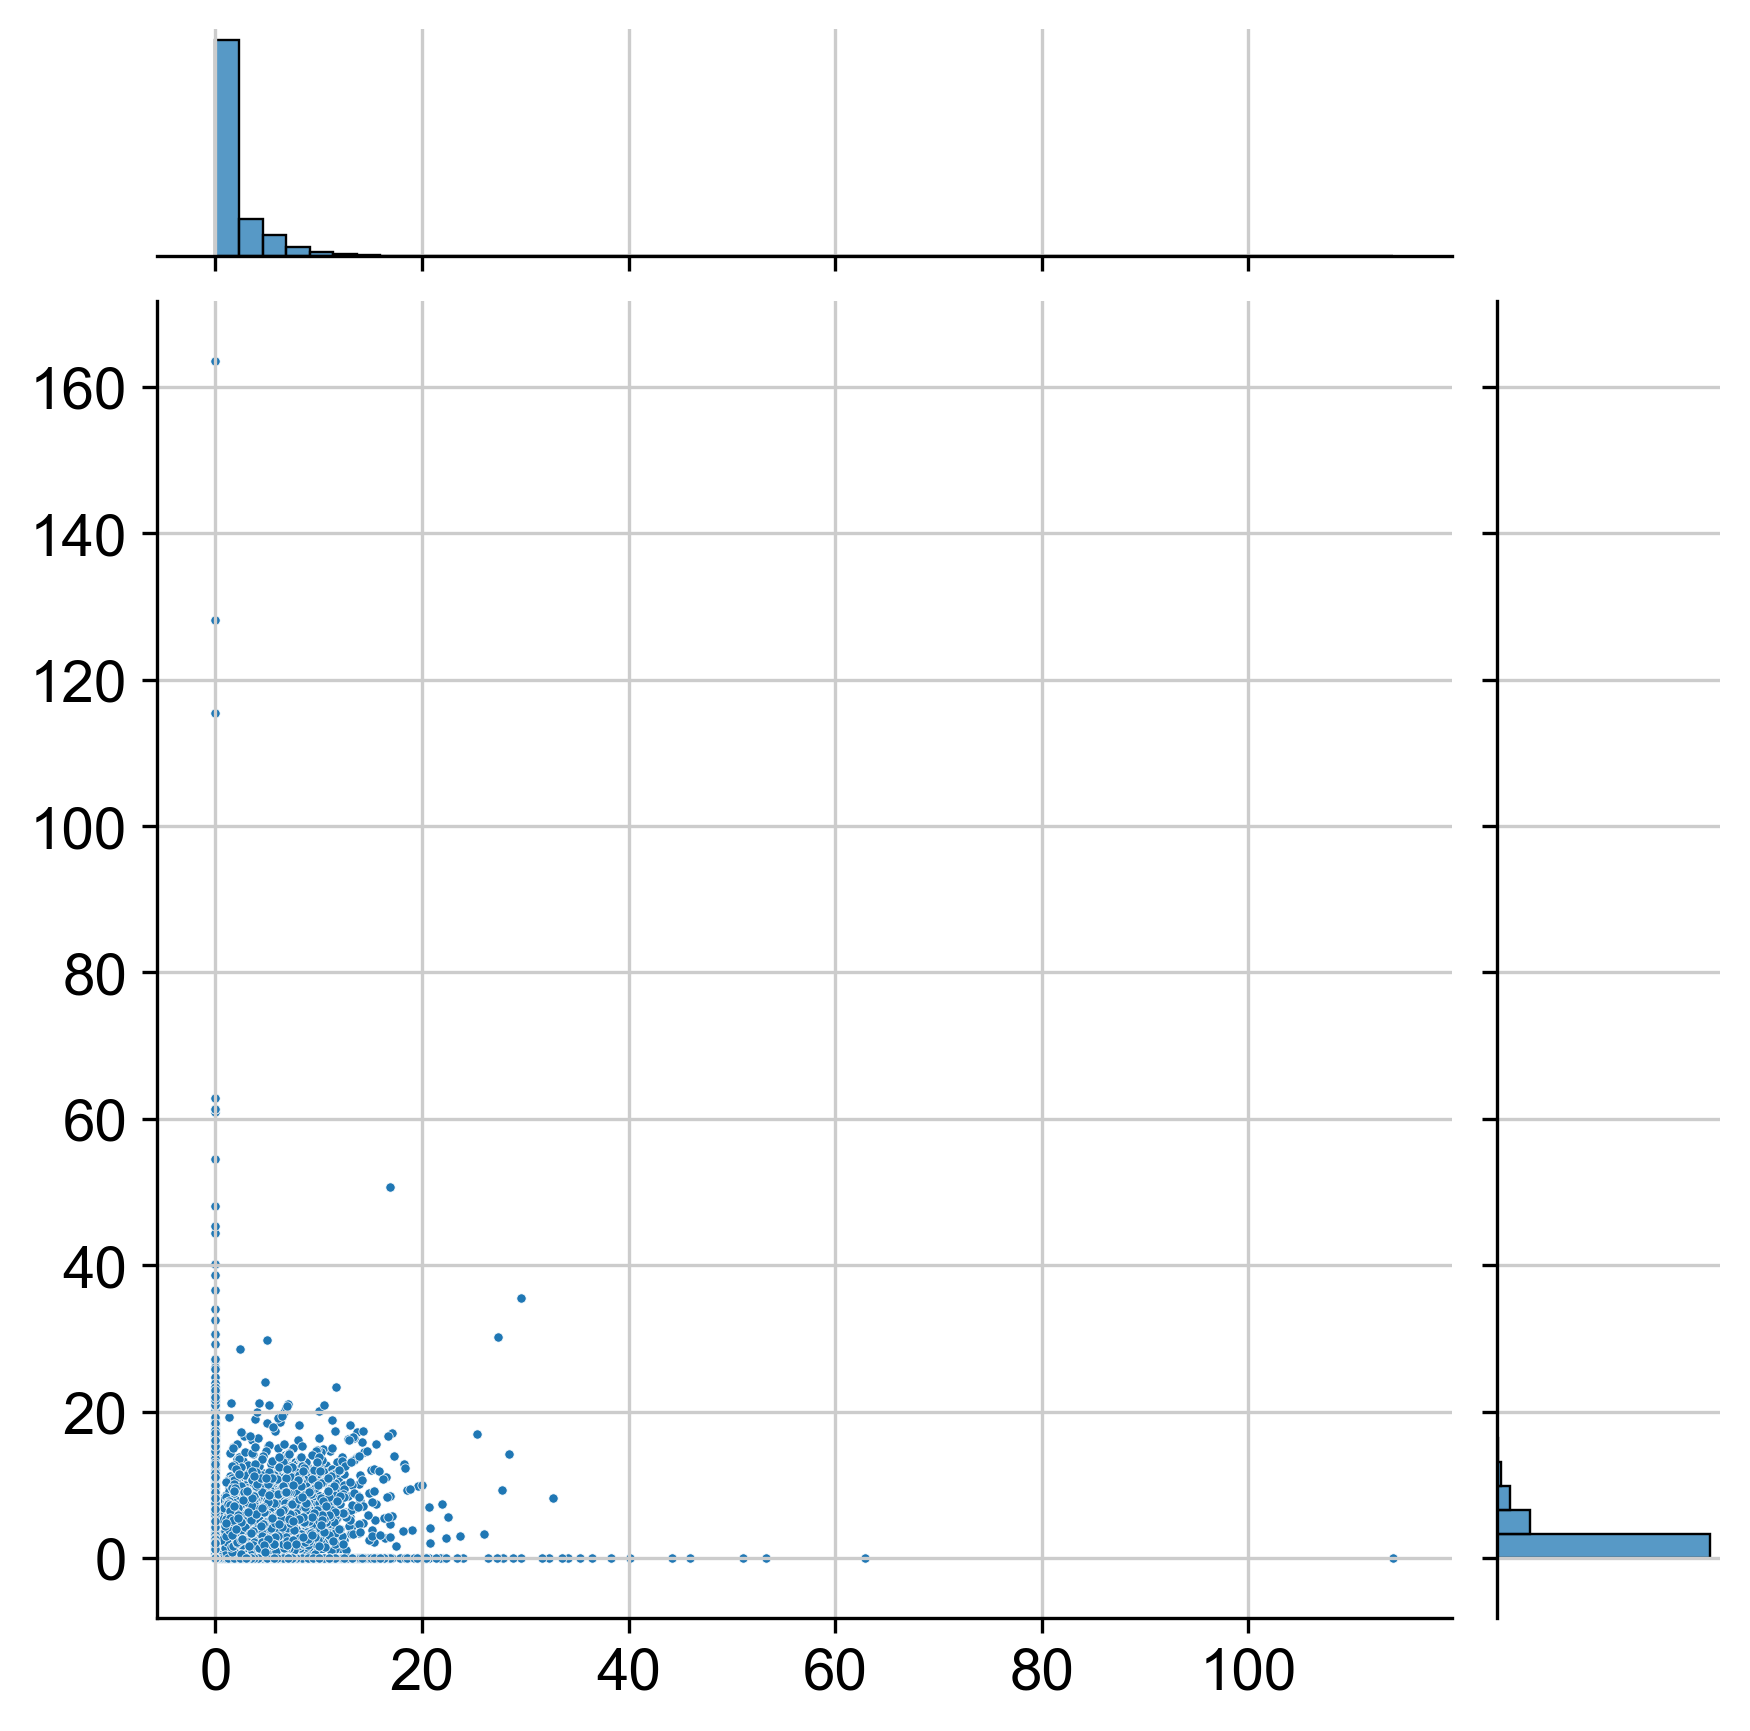

In [253]:
def plot_gex(g1, g2, ndata):
    gn1 = numpy.array(ndata.X[:,ndata.var.index.tolist().index(g1)].T.todense())[0]
    gn2 = numpy.array(ndata.X[:,ndata.var.index.tolist().index(g2)].T.todense())[0]
    plt.figure()
    sns.jointplot(x=gn1,y=gn2,s=5,marginal_kws=dict(bins=50))
    mi = calc_mi(g1,g2,ndata)
    plt.show()
# adata = sc.read("tica.h5ad")
# sc.pp.log1p(adata)
plot_gex("CD3E","CD3D",adatas["norm"])

In [180]:
import itertools
from scipy import stats
for r in set(midf["Norm"]):
    combinations = itertools.combinations(set(midf["Pair Type"]),2)
    dfx = midf[midf["Norm"] == r]
    for x,y in combinations:
        df1 = dfx[dfx["Pair Type"] == "Coex"]
        df2 = dfx[dfx["Pair Type"] == "Excl"]
        res = stats.mannwhitneyu(df1['MI'],df2['MI'], alternative="less")
        print(r,x,"vs",y,res.pvalue)

raw Coex vs Excl 1.0
lognorm Coex vs Excl 1.1331398505657735e-08
norm Coex vs Excl 8.888870039310986e-12
log Coex vs Excl 1.0


In [123]:
import collections
raw_specific =  collections.defaultdict(set)
import tqdm
for n, p in zip(dfx["Norm"],dfx["pair"]):
    raw_specific[n].add(p)

In [130]:
rawu = raw_specific["log"].difference(raw_specific["lognorm"])
rawu = rawu.difference(raw_specific["raw"])
rawu = rawu.difference(raw_specific["norm"])
rawu

{'TWISTNB-TOB1',
 'CPVL-ANXA1',
 'TNFAIP3-GRN',
 'CD69-CD7',
 'CD83-MYADM',
 'TRBV29.1-LINC00892',
 'RTKN2-CDO1',
 'SYNE2-CD7',
 'IGKV1.8-IGLL5',
 'PPP1R14A-CA2',
 'GBP1-DNAJB1',
 'KIF20B-CXCR3',
 'ADAM19-TCOF1',
 'DNAJB1-HLA.DPA1',
 'HMGB2-FGL2',
 'TCOF1-PLEK',
 'PLEK-ANKRD28',
 'ALOX5AP-TXN',
 'LTA-RP5.1028K7.2',
 'PIM2-ATF3',
 'TRAV8.1-CHI3L2',
 'IER5-TFRC',
 'MS4A6A-PMAIP1',
 'ADRB2-TSC22D1',
 'DNAJB1-SOCS3',
 'PIM2-GPR183',
 'LDLRAD4-PLIN2',
 'CST7-MTRNR2L12',
 'TNFSF13B-GPR183',
 'BIRC3-SOCS3',
 'TNFRSF25-TIGIT',
 'LGALS2-AREG',
 'C1QC-KCNQ1OT1',
 'DDIT4-MAF',
 'SLC2A3-CD3D',
 'EGR1-STAB1',
 'HSPA1B-TUBA1B',
 'EOMES-GPR171',
 'CTSW-STMN1',
 'GLA-ACTB',
 'GZMM-ICOS',
 'ACP5-HSPH1',
 'CXCR6-STAG3',
 'SMC4-ITM2C',
 'RTKN2-TRDV1',
 'AKR1C3-AC069363.1',
 'HLA.DRA-KPNA2',
 'AREG-TGFBI',
 'TMEM107-WARS',
 'TFRC-LGMN',
 'TSC22D1-ADRB2',
 'TWISTNB-IFI30',
 'IGHV4.59-POU2AF1',
 'CD69-ENTPD1',
 'RP11.1399P15.1-HLA.DPA1',
 'RP11.1399P15.1-CD3G',
 'ISG15-MT2A',
 'RP11.1143G9.4-CREM',
 'NEAT1-

In [131]:
output = open("/Users/ceglian/log_only_pairs.txt","w")
for x in rawu:
    output.write(x+"\n")
output.close()

In [132]:
genes = set()
for p in rawu:
    p1,p2 = p.split("-")
    genes.add(p1)
    genes.add(p2)

In [133]:
len(genes)

746

In [134]:
import gseapy as gp
enr = gp.enrichr(gene_list=list(genes), # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


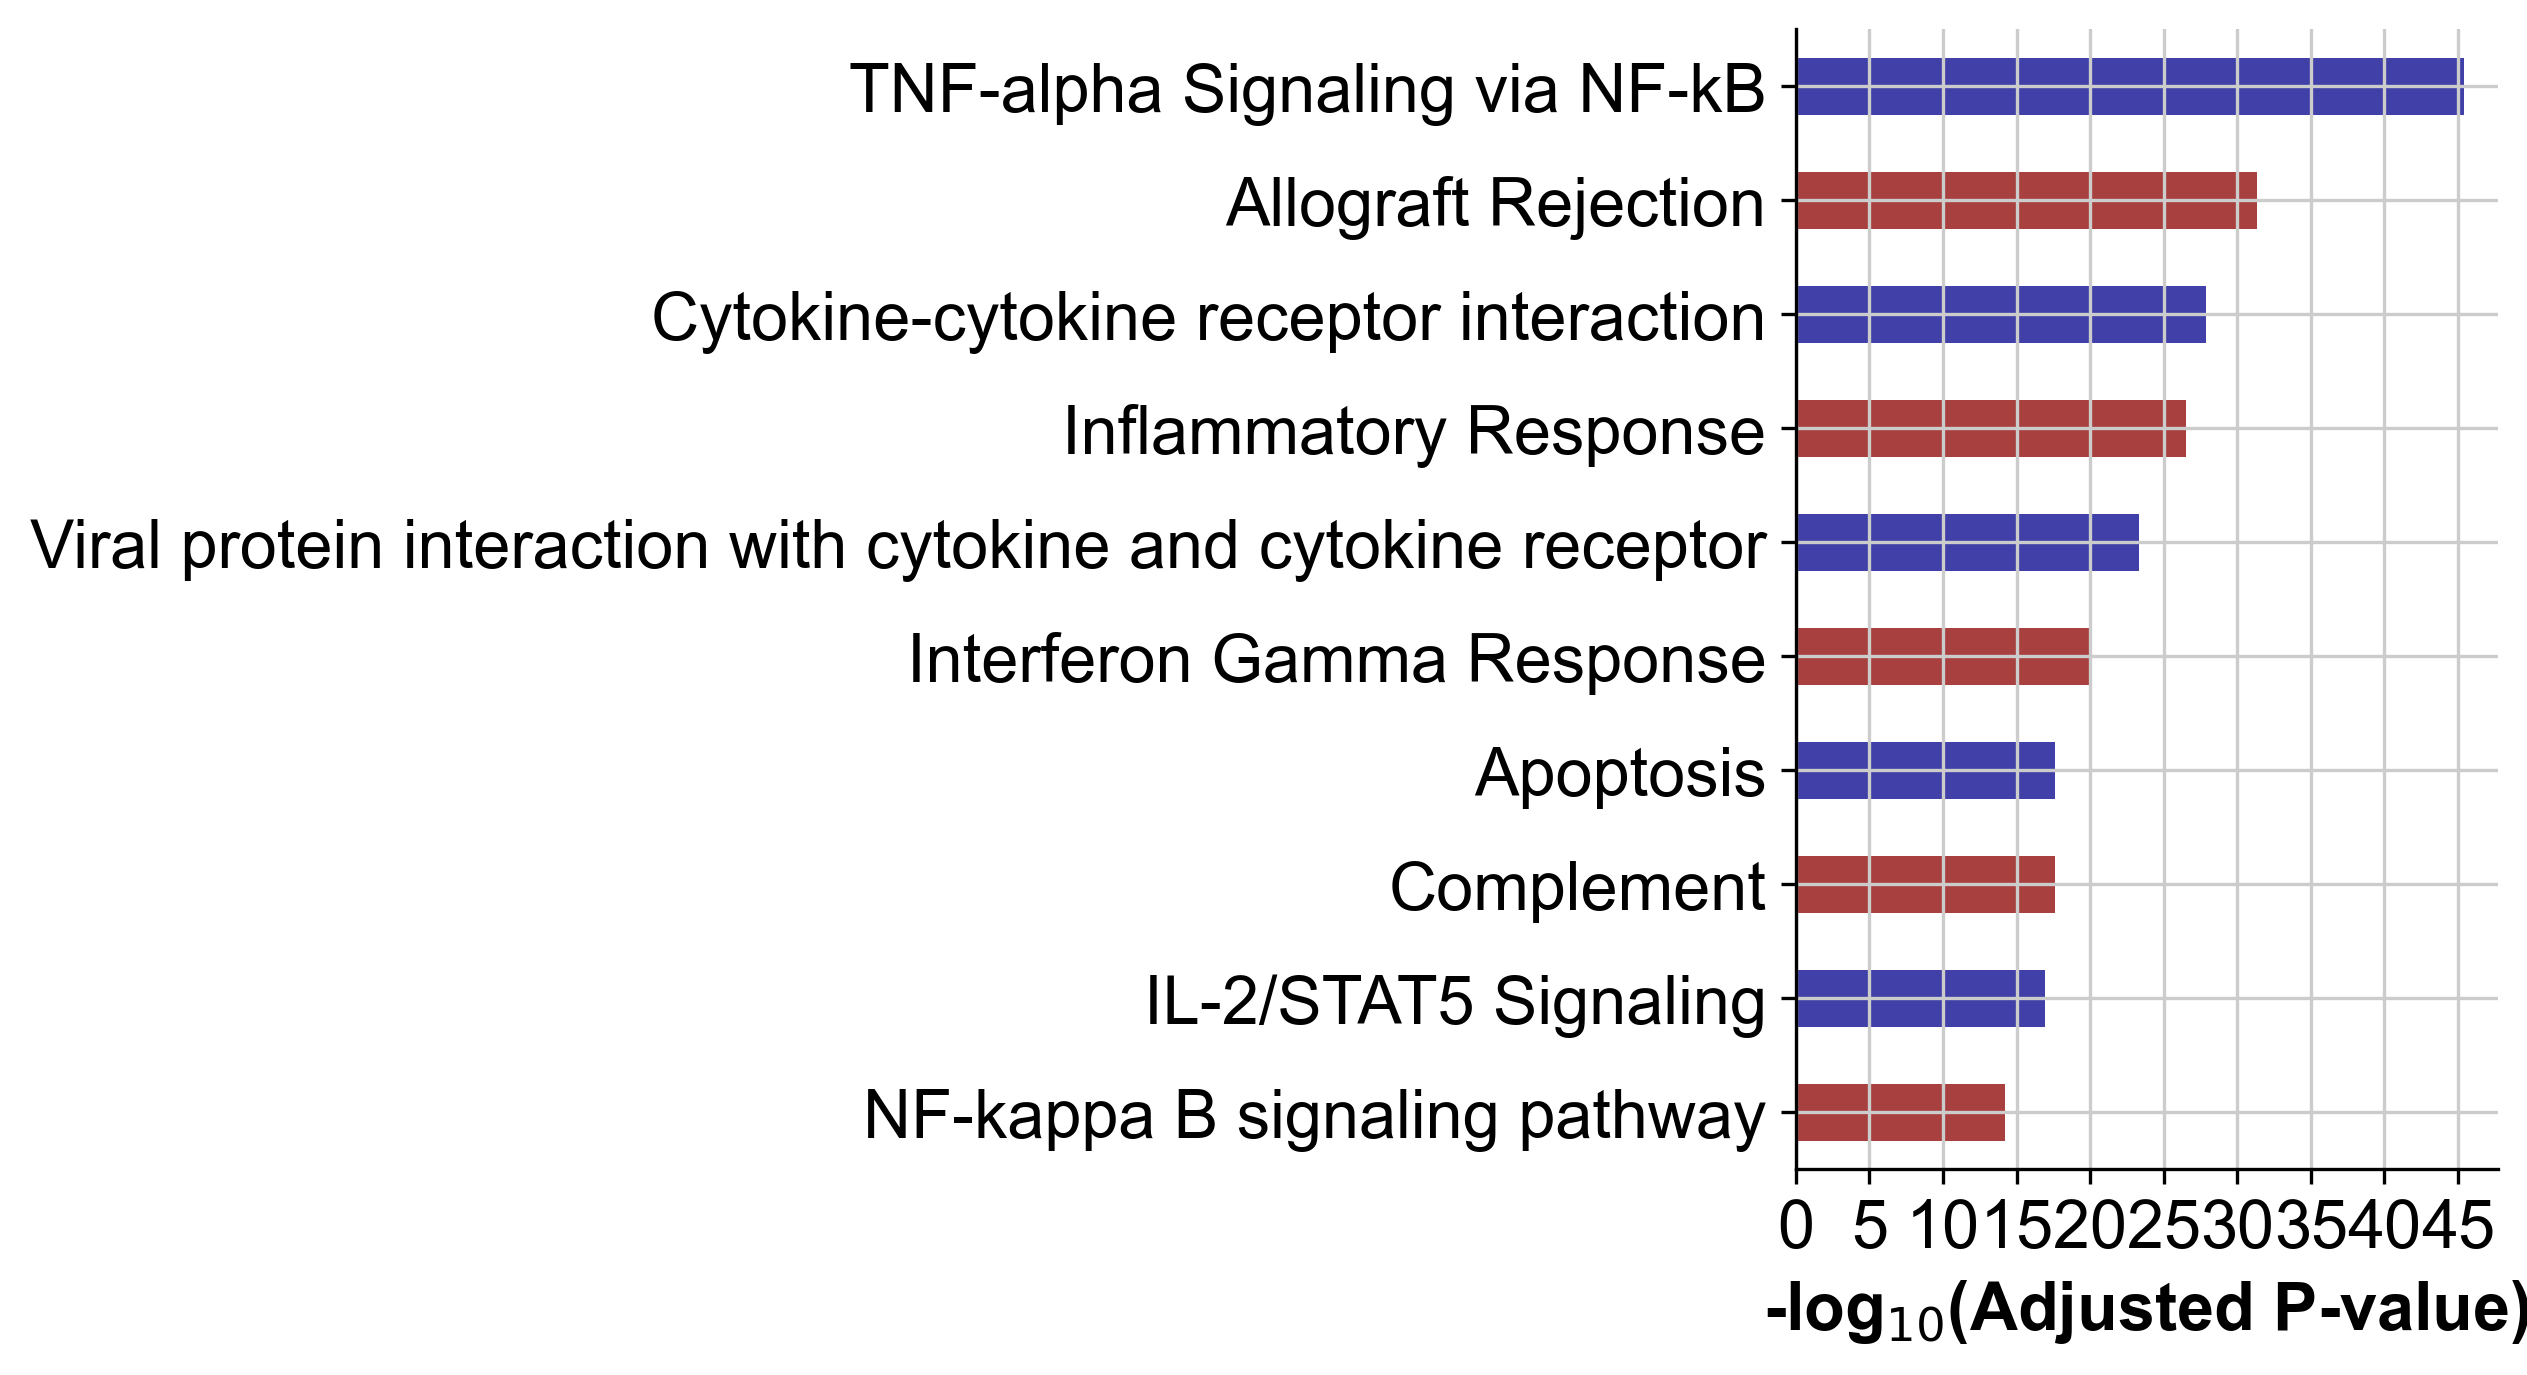

In [135]:
from gseapy import barplot, dotplot
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              color=['darkred', 'darkblue'] # set colors for group
             )

In [ ]:
rank = numpy.max(df["distance"]) - df["distance"]

In [139]:
import itertools
from scipy import stats
for r in set(df["Source"]):
    combinations = itertools.combinations(set(df["Norm"]),2)
    dfx = df[df["Source"] == r]
    for x,y in combinations:
        df1 = dfx[dfx["Norm"] == x]
        df2 = dfx[dfx["Norm"] == y]
        res = stats.mannwhitneyu(df1['rank'],df2['rank'])
        print(r,x,"vs",y,res.pvalue)

Unannotated raw vs lognorm 9.038722309326276e-21
Unannotated raw vs norm 0.0
Unannotated raw vs log 0.0
Unannotated lognorm vs norm 0.0
Unannotated lognorm vs log 0.0
Unannotated norm vs log 6.039149866203778e-51
Reactome raw vs lognorm 4.997289504470681e-73
Reactome raw vs norm 3.2394059812177465e-43
Reactome raw vs log 5.618332906681803e-57
Reactome lognorm vs norm 3.841147151121165e-06
Reactome lognorm vs log 0.008379167938396794
Reactome norm vs log 0.027983060536241333
Multiple raw vs lognorm 4.11413406198032e-133
Multiple raw vs norm 0.0
Multiple raw vs log 0.0
Multiple lognorm vs norm 0.0
Multiple lognorm vs log 0.0
Multiple norm vs log 1.2631554955104063e-19
MSigDB Cell Type raw vs lognorm 0.0
MSigDB Cell Type raw vs norm 0.0
MSigDB Cell Type raw vs log 0.0
MSigDB Cell Type lognorm vs norm 0.0
MSigDB Cell Type lognorm vs log 0.0
MSigDB Cell Type norm vs log 0.3168076668314681
Trrust raw vs lognorm 0.18460659362645326
Trrust raw vs norm 1.3000615723716294e-18
Trrust raw vs log 0

In [65]:
numpy.median(df["rank"])

498511.0